# surface lenght

In [21]:
import skfmm
from scipy.ndimage import distance_transform_edt
from scipy.signal import convolve2d
from main import *

from glob import glob

import seaborn as sns

import pandas as pd

from tqdm import tqdm

import os
import string

In [22]:
folder = 'sulov_folder'
files = glob(folder + '/BIN-*points.tif')
files

names = [os.path.basename(f)[:-11] for f in files]
names

n = len(names)

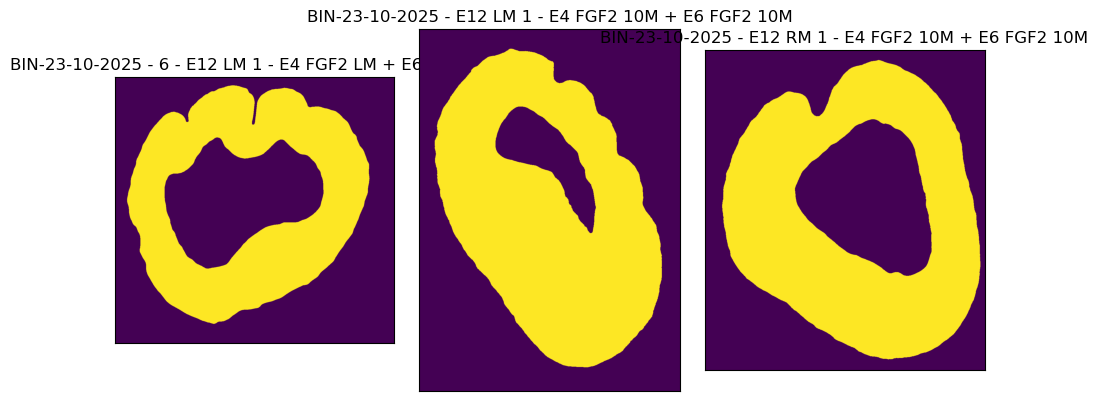

In [23]:
fig, axs = plt.subplots(1, n, figsize = (3*n,4))

for i, name in enumerate(names):

    donut, res = get_picture2D(f'{folder}/{name}.tif')

    axs[i].set_title(name)
    axs[i].imshow(donut)


for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()


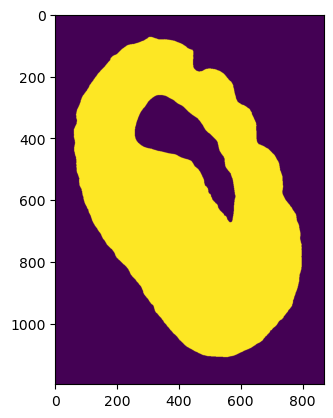

In [68]:
donut, res = get_picture2D(f'{folder}/{names[1]}.tif')

plt.imshow(donut)


donut = np.pad(donut, pad_width=10, mode='constant', constant_values=0)

plt.imshow(donut)


smoothing factor = 10.00


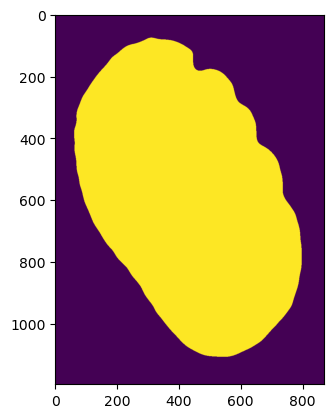

In [69]:
donut = smoothing(donut, 10)

donut_mask = donut != 0

# we should have only ventricle and outside regions
labeled, n = label(~ donut_mask)

if n != 2:
    raise ValueError('problem with masks, too many regions')

# outside label is the label of the pixel on the top left
outside_label = labeled[(0,0)]
outside_mask = labeled == outside_label
# ventricle is the other region
ventr_mask = (labeled != outside_label) & (~ donut_mask)

tissue = ~outside_mask


plt.imshow(tissue)

In [70]:
def dist(p0, p1, res=(1,1)):
    return np.hypot((p1[0]-p0[0])*res[0],
                    (p1[1]-p0[1])*res[1])

def len_edge(shape, res=(1,1)):
    edge = find_edge(shape)

    edge = ordered_edge_points(edge)

    l = 0

    for i, p in enumerate(edge):
        if i==0:
            l_step = dist(p, edge[-1], res=res)
        else:
            l_step = dist(p, edge[i-1], res=res)

        l += l_step

    return l

In [71]:
len_edge(tissue, res=res)

np.float64(941.5688942441627)

In [72]:
from scipy.spatial import ConvexHull
from matplotlib.path import Path


points = np.column_stack(np.nonzero(tissue))

hull = ConvexHull(points)

hull_coords = points[hull.vertices]

yy, xx = np.mgrid[0:tissue.shape[0], 0:tissue.shape[1]]
coords = np.column_stack((yy.ravel(), xx.ravel()))

path = Path(hull_coords)
inside = path.contains_points(coords)
hull_mask = inside.reshape(tissue.shape)

len_edge(hull_mask, res=res)

np.float64(926.3180869842572)

In [73]:
def get_edge_coords(shape):
    edge = ordered_edge_points(find_edge(shape))
    edge = np.array(edge)

    xs = edge[:,0]
    ys = edge[:,1]

    return xs, ys

In [ ]:
len_surf = len_edge(tissue, res=res)
len_hull = len_edge(hull_mask, res=res)

surface: 941.6
convex: 926.3


([], [])

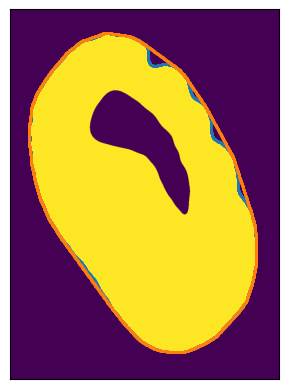

In [ ]:
print(f'surface = {len_surf:.1f} --- convex = {len_hull:.1f}')
print(f'GI = {len_surf/len_hull:.2f}')

plt.imshow(donut)

plt.scatter(*get_edge_coords(tissue)[::-1], s=1)
plt.scatter(*get_edge_coords(hull_mask)[::-1], s=1)

plt.xticks([])
plt.yticks([])